In [ ]:
import os
import sys
import torch
import json
import plotly.express as px
from transformer_lens import utils
from datasets import load_dataset
from typing import  Dict
from pathlib import Path

from functools import partial

import argparse
import itertools
import os
import pickle
from collections.abc import Generator
from dataclasses import dataclass, field
from datetime import datetime
from typing import Any, List, Optional, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from scipy.stats import ortho_group
from tqdm import tqdm

import torch
from torch.optim import Adam
from tqdm import tqdm
from transformer_lens import HookedTransformer

import wandb
from sae_training.activations_store import ActivationsStore
from sae_training.evals import run_evals
from sae_training.optim import get_scheduler
from sae_training.sparse_autoencoder import SparseAutoencoder
from sae_training.sae_group import SAEGroup

sys.path.append("..")

from sae_training.utils import LMSparseAutoencoderSessionloader
from sae_analysis.visualizer.data_fns import get_feature_data, FeatureData

if torch.backends.mps.is_available():
    device = "mps" 
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_grad_enabled(False)

In [ ]:
# Start by downloading them from huggingface
from huggingface_hub import hf_hub_download
REPO_ID = "Benw8888/lp_saes"
layer = 6 # any layer from 0 - 11 works here
uuid_str = "vg840plj"
local_folder = f"/root/mats_sae_training/checkpoints/{uuid_str}"
file_strings = [
    "final_sae_group_EleutherAI_pythia-14m_blocks.3.hook_resid_pre_8192_log_feature_sparsity.pt",
    "final_sae_group_EleutherAI_pythia-14m_blocks.3.hook_resid_pre_8192.pt",
]
fs = file_strings[-1]

# FILENAME = f"{uuid_str}/final_sae_group_gpt2-small_blocks.{layer}.hook_resid_pre_49152.pt"

# path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
path = f"/root/mats_sae_training/checkpoints/{uuid_str}/{fs}"

In [ ]:
# We can then load the SAE, dataset and model using the session loader
model, sae_group, activation_store = LMSparseAutoencoderSessionloader.load_session_from_pretrained(
    path = path
)
log_frequencies = torch.load(f"/root/mats_sae_training/checkpoints/{uuid_str}/{file_strings[0]}")

In [12]:
for i, sae in enumerate(sae_group):
    hyp = sae.cfg
    print(f"{i}: Layer {hyp.hook_point_layer}, p_norm {hyp.lp_norm}, alpha {hyp.l1_coefficient}")

0: Layer 3, p_norm 0.6, alpha 3e-09
1: Layer 3, p_norm 0.8, alpha 3e-09
2: Layer 3, p_norm 0.6, alpha 5.6e-09
3: Layer 3, p_norm 0.8, alpha 5.6e-09
4: Layer 3, p_norm 0.6, alpha 1e-08
5: Layer 3, p_norm 0.8, alpha 1e-08
6: Layer 3, p_norm 0.6, alpha 1.8e-08
7: Layer 3, p_norm 0.8, alpha 1.8e-08
8: Layer 3, p_norm 0.6, alpha 3e-08
9: Layer 3, p_norm 0.8, alpha 3e-08
10: Layer 3, p_norm 0.6, alpha 5.6e-08
11: Layer 3, p_norm 0.8, alpha 5.6e-08
12: Layer 3, p_norm 0.6, alpha 1e-07
13: Layer 3, p_norm 0.8, alpha 1e-07
14: Layer 3, p_norm 0.6, alpha 1.8e-07
15: Layer 3, p_norm 0.8, alpha 1.8e-07
16: Layer 3, p_norm 0.6, alpha 3e-07
17: Layer 3, p_norm 0.8, alpha 3e-07
18: Layer 3, p_norm 0.6, alpha 5.6e-07
19: Layer 3, p_norm 0.8, alpha 5.6e-07
20: Layer 3, p_norm 0.6, alpha 1e-06
21: Layer 3, p_norm 0.8, alpha 1e-06
22: Layer 3, p_norm 0.6, alpha 1.8e-06
23: Layer 3, p_norm 0.8, alpha 1.8e-06
24: Layer 3, p_norm 0.6, alpha 3e-06
25: Layer 3, p_norm 0.8, alpha 3e-06
26: Layer 3, p_norm 0.6,

Helper Functions

In [ ]:
def cosine_sim(
    vecs1: Union[torch.Tensor, torch.nn.parameter.Parameter, npt.NDArray],
    vecs2: Union[torch.Tensor, torch.nn.parameter.Parameter, npt.NDArray],
) -> np.ndarray:
    vecs = [vecs1, vecs2]
    for i in range(len(vecs)):
        if not isinstance(vecs[i], np.ndarray):
            vecs[i] = vecs[i].detach().cpu().numpy()  # type: ignore
    vecs1, vecs2 = vecs
    normalize = lambda v: (v.T / np.linalg.norm(v, axis=1)).T
    vecs1_norm = normalize(vecs1)
    vecs2_norm = normalize(vecs2)

    return vecs1_norm @ vecs2_norm.T

class BatchCorrelationCalculator:
    def __init__(self, feature_dim_x, feature_dim_y, device="cpu"):
        # Initialize sums needed for correlation calculation for each feature dimension
        self.sum_x = torch.zeros(feature_dim_x, device=device)
        self.sum_y = torch.zeros(feature_dim_y, device=device)
        self.sum_x2 = torch.zeros(feature_dim_x, device=device)
        self.sum_y2 = torch.zeros(feature_dim_y, device=device)
        self.sum_xy = torch.zeros(
            (feature_dim_x, feature_dim_y), device=device
        )  # This now becomes a matrix
        self.n = 0
        self.device = device

    def update(self, x_batch, y_batch):
        # Ensure input batches are torch tensors
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        # Update running sums with a new batch
        self.sum_x += torch.sum(x_batch, dim=0)
        self.sum_y += torch.sum(y_batch, dim=0)
        self.sum_x2 += torch.sum(x_batch**2, dim=0)
        self.sum_y2 += torch.sum(y_batch**2, dim=0)
        for i in range(x_batch.shape[1]):  # Iterate over features in x
            for j in range(y_batch.shape[1]):  # Iterate over features in y
                self.sum_xy[i, j] += torch.sum(x_batch[:, i] * y_batch[:, j])
        self.n += x_batch.shape[0]

    def compute_correlation(self):
        # Compute Pearson correlation coefficient matrix between features of the two vectors
        numerator = self.n * self.sum_xy - torch.ger(self.sum_x, self.sum_y)
        denominator = torch.sqrt(
            torch.ger(self.n * self.sum_x2 - self.sum_x**2, self.n * self.sum_y2 - self.sum_y**2)
        )

        # Handle division by zero for cases with no variance
        valid = denominator != 0
        correlation_matrix = torch.zeros_like(denominator)
        correlation_matrix[valid] = numerator[valid] / denominator[valid]

        # Set correlations to 0 where denominator is 0 (indicating no variance)
        correlation_matrix[~valid] = 0

        return correlation_matrix

# Running Metric Evals

In [ ]:
def wandb_log_suffix(cfg, hyperparams):
    # Create a mapping from cfg list keys to their corresponding hyperparams attributes
    key_mapping = {
        "hook_point_layer": "layer",
        "l1_coefficient": "coeff",
        "lp_norm": "l",
        "lr": "lr"
    }

    # Generate the suffix by iterating over the keys that have list values in cfg
    suffix = "".join(f"_{key_mapping.get(key, key)}{getattr(hyperparams, key, '')}" 
                    for key, value in vars(cfg).items() if isinstance(value, list))
    return suffix

batch_size=sae_group.cfg.train_batch_size
feature_sampling_window=sae_group.cfg.feature_sampling_window
dead_feature_threshold=sae_group.cfg.dead_feature_threshold
use_wandb=sae_group.cfg.log_to_wandb
wandb_log_frequency=1  # sae_group.cfg.wandb_log_frequency # should we log faster when evaluating?

# Only run evals for less time than training:
total_training_tokens = 1_000_000
total_training_steps = total_training_tokens // batch_size
n_training_steps = 0
n_training_tokens = 0


wandb.init(project=sae_group.cfg.wandb_project, config=sae_group.cfg, name=f"eval_{sae_group.cfg.run_name}")


# things to store for each sae:
# act_freq_scores, n_forward_passes_since_fired, n_frac_active_tokens, optimizer, scheduler, 
num_saes = len(sae_group)
# track active features

act_freq_scores = [
    torch.zeros(
        sparse_autoencoder.cfg.d_sae, device=sparse_autoencoder.cfg.device
    ) for sparse_autoencoder in sae_group
]
n_forward_passes_since_fired = [
    torch.zeros(
        sparse_autoencoder.cfg.d_sae, device=sparse_autoencoder.cfg.device
    ) for sparse_autoencoder in sae_group
]
n_frac_active_tokens = [0  for _ in range(num_saes)]
corr_calculator = [
    BatchCorrelationCalculator(sparse_autoencoder.cfg.d_sae, sparse_autoencoder.cfg.d_sae)
    for sparse_autoencoder in sae_group
]


all_layers = sae_group.cfg.hook_point_layer
if not isinstance(all_layers, list):
    all_layers = [all_layers]
    
# compute the geometric median of the activations of each layer

with torch.no_grad():
    pbar = tqdm(total=total_training_tokens, desc="Evaluating SAE")
    while n_training_tokens < total_training_tokens:
        # Do a training step.
        layer_acts = activation_store.next_batch()
        n_training_tokens += batch_size
        
        for i, (sparse_autoencoder), in enumerate(sae_group):
            hyperparams = sparse_autoencoder.cfg
            layer_id = all_layers.index(hyperparams.hook_point_layer)
            sae_in = layer_acts[:,layer_id,:]
            
            sparse_autoencoder.eval()
            # Make sure the W_dec is still zero-norm
            sparse_autoencoder.set_decoder_norm_to_unit_norm()

            # # log and then reset the feature sparsity every feature_sampling_window steps
            # if (n_training_steps + 1) % feature_sampling_window == 0:
            #     feature_sparsity = act_freq_scores[i] / n_frac_active_tokens[i]
            #     log_feature_sparsity = torch.log10(feature_sparsity + 1e-10).detach().cpu()

            #     if use_wandb:
            #         suffix = wandb_log_suffix(sae_group.cfg, hyperparams)
            #         wandb_histogram = wandb.Histogram(log_feature_sparsity.numpy())
            #         wandb.log(
            #             {
            #                 f"metrics/mean_log10_feature_sparsity{suffix}": log_feature_sparsity.mean().item(),
            #                 f"plots/feature_density_line_chart{suffix}": wandb_histogram,
            #                 f"sparsity/below_1e-5{suffix}": (feature_sparsity < 1e-5).sum().item(),
            #                 f"sparsity/below_1e-6{suffix}": (feature_sparsity < 1e-6).sum().item(),
            #             },
            #             step=n_training_steps,
            #         )

            #     act_freq_scores[i] = torch.zeros(
            #         sparse_autoencoder.cfg.d_sae, device=sparse_autoencoder.cfg.device
            #     )
            #     n_frac_active_tokens[i] = 0

            # ghost_grad_neuron_mask = (
            #     n_forward_passes_since_fired[i] > sparse_autoencoder.cfg.dead_feature_window
            # ).bool()
            

            # # Forward and Backward Passes
            # (
            #     sae_out,
            #     feature_acts,
            #     loss,
            #     mse_loss,
            #     l1_loss,
            #     ghost_grad_loss,
            # ) = sparse_autoencoder(
            #     sae_in,
            #     ghost_grad_neuron_mask,
            # )
            # did_fire = (feature_acts > 0).float().sum(-2) > 0
            # n_forward_passes_since_fired[i] += 1
            # n_forward_passes_since_fired[i][did_fire] = 0
            
            # # Update auto-correlation tracker
            # # corr_calculator[i].update(feature_acts, feature_acts)

            # # Calculate the sparsities, and add it to a list, calculate sparsity metrics
            # act_freq_scores[i] += (feature_acts.abs() > 0).float().sum(0)
            # n_frac_active_tokens[i] += batch_size
            # feature_sparsity = act_freq_scores[i] / n_frac_active_tokens[i]

            # if use_wandb and ((n_training_steps + 1) % wandb_log_frequency == 0):
            #     # metrics for currents acts
            #     l0 = (feature_acts > 0).float().sum(-1).mean()

            #     per_token_l2_loss = (sae_out - sae_in).pow(2).sum(dim=-1).squeeze()
            #     total_variance = (sae_in - sae_in.mean(0)).pow(2).sum(-1)
            #     explained_variance = 1 - per_token_l2_loss / total_variance

            #     suffix = wandb_log_suffix(sae_group.cfg, hyperparams)
            #     wandb.log(
            #         {
            #             # losses
            #             f"losses/mse_loss{suffix}": mse_loss.item(),
            #             f"losses/l1_loss{suffix}": l1_loss.item()
            #             / sparse_autoencoder.l1_coefficient,  # normalize by l1 coefficient
            #             f"losses/ghost_grad_loss{suffix}": ghost_grad_loss.item(),
            #             f"losses/overall_loss{suffix}": loss.item(),
            #             # variance explained
            #             f"metrics/explained_variance{suffix}": explained_variance.mean().item(),
            #             f"metrics/explained_variance_std{suffix}": explained_variance.std().item(),
            #             f"metrics/l0{suffix}": l0.item(),
            #             # sparsity
            #             f"sparsity/mean_passes_since_fired{suffix}": n_forward_passes_since_fired[i].mean().item(),
            #             f"sparsity/dead_features{suffix}": ghost_grad_neuron_mask.sum().item(),
            #             f"details/n_training_tokens{suffix}": n_training_tokens,
            #         },
            #         step=n_training_steps,
            #     )

            # record evals more frequently than while training
            if use_wandb and ((n_training_steps) % (wandb_log_frequency) == 0):
                sparse_autoencoder.eval()
                suffix = wandb_log_suffix(sae_group.cfg, hyperparams)
                run_evals(sparse_autoencoder, activation_store, model, n_training_steps, suffix=suffix)
                sparse_autoencoder.train()
                
        n_training_steps += 1
        # pbar.set_description(
        #     f"{n_training_steps}| MSE Loss {mse_loss.item():.3f} | L1 {l1_loss.item():.3f}"
        # )
        pbar.update(batch_size)

In [ ]:
wandb.finish()

# Plot Cosine Sims

In [25]:
id = 30
sae = list(sae_group)[id]
sae_lfreq = log_frequencies[id]
hyp = sae.cfg
print(f"Layer {hyp.hook_point_layer}, p_norm {hyp.lp_norm}, alpha {hyp.l1_coefficient}")

Layer 3, p_norm 0.6, alpha 1.8e-05


In [37]:
def get_cosims(sae, log_freq=None, threshold=1e-6):
    feats = sae.W_dec.data
    if log_freq is not None:
        alive = log_freq > np.log10(1e-6)
        feats = feats[alive]
    
    normed_feats = nn.functional.normalize(feats, dim=1)
    cosim_matrix = (
        (
            normed_feats
            @ normed_feats.mT
        )
        .detach()
        .cpu()
    )
    return cosim_matrix

Text(0.5, 1.0, 'SAE Features Cosine Similarity (L0.6)')

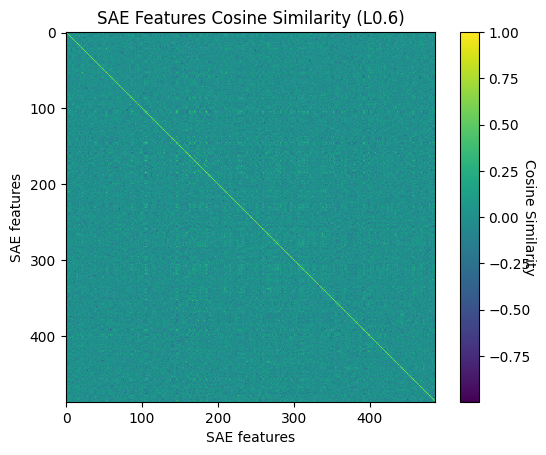

In [38]:
cosim_matrix = get_cosims(sae,sae_lfreq)
p_name = "0.6"
sorted_cosim_matrix = cosim_matrix #.sort(descending=True, dim=-1)[0].cpu()
plt.imshow(sorted_cosim_matrix)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cosine Similarity', rotation=270)
plt.xlabel("SAE features")
plt.ylabel("SAE features")
plt.title(f"SAE Features Cosine Similarity (L{p_name})")
# plt.savefig(f"images_{cfg.seed}/ffl{p_name}.png")

In [60]:
def mncs(sae, log_freq=None, threshold=None):
    cosim_matrix = get_cosims(sae, log_freq, threshold)
    for i in range(cosim_matrix.shape[0]):
        cosim_matrix[i,i] = 0
    return cosim_matrix.max(dim=0)[0].mean()

In [61]:
mncs(sae,sae_lfreq)

tensor(0.3795)

# Analyzing L1

In [50]:
uuid_str = "uloaub10"
path = f"/root/mats_sae_training/checkpoints/{uuid_str}/{file_strings[-1]}"
sae_group_l1 = torch.load(path)
log_frequencies_l1 = torch.load(f"/root/mats_sae_training/checkpoints/{uuid_str}/{file_strings[0]}")

In [52]:
id = 9
sae_l1 = list(sae_group_l1)[id]
sae_lfreq_l1 = log_frequencies_l1[id]
hyp = sae_l1.cfg
print(f"Layer {hyp.hook_point_layer}, p_norm {hyp.lp_norm}, alpha {hyp.l1_coefficient}")

Layer 3, p_norm 1, alpha 0.00133


Text(0.5, 1.0, 'SAE Features Cosine Similarity (L1)')

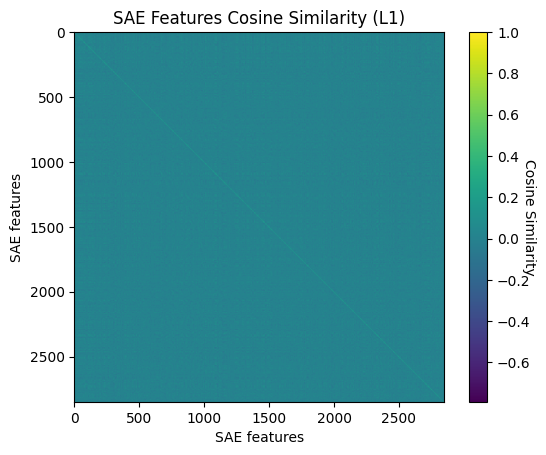

In [53]:
cosim_matrix = get_cosims(sae_l1,sae_lfreq_l1)
p_name = "1"
sorted_cosim_matrix = cosim_matrix #.sort(descending=True, dim=-1)[0].cpu()
plt.imshow(sorted_cosim_matrix)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cosine Similarity', rotation=270)
plt.xlabel("SAE features")
plt.ylabel("SAE features")
plt.title(f"SAE Features Cosine Similarity (L{p_name})")
# plt.savefig(f"images_{cfg.seed}/ffl{p_name}.png")

In [62]:
mncs(sae_l1,sae_lfreq_l1)

tensor(0.6207)